In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Main Implementation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [3]:
#  I have tried with EarlyStopping monitoring val_loss and val_acc, however running the model for higher number of epochs always gives the best resutls
# from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [4]:
main_dir = "./train_dataset/"
train_dir = main_dir + "train"
test_dir = main_dir + "test"

validation_split = 0.1
batch_size = 32
IMG_Shape = 224

In [5]:
import albumentations as A
from PIL import Image

In [6]:
train_basic = A.Compose([
  A.Resize(224, 224)
])

train_transform = A.Compose([
    A.Rotate(limit=40, p=0.75),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0, p=0.75),
    A.HorizontalFlip(p=0.5),
    A.Resize(224, 224),

])

In [7]:
def load_train_images_from_folder(folder):
    images = []
    labels = []
    for dir in os.listdir(folder):
      for filename in os.listdir(os.path.join(folder,dir)):
          image_path = os.path.join(folder,dir, filename)
          label = int(dir[-1])-1
          image = Image.open(image_path)
          augmented = train_transform(image=np.array(image))
          augmented_image = augmented['image']
          images.append(augmented_image)
          labels.append(label)
          del augmented_image
          image = train_basic(image=np.array(image))
          image = image['image']
          images.append(image)
          labels.append(label)
          del image

      print(f"Finished {dir}")
    return np.array(images)/255.0, np.array(labels)

In [8]:
X, y = load_train_images_from_folder(train_dir)

Finished class3
Finished class4
Finished class5
Finished class2
Finished class1


In [9]:
print(X.shape, y.shape)

(650, 224, 224, 3) (650,)


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, shuffle=True, stratify=y)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [11]:
modelA = Sequential([
        Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        MaxPooling2D((3,3), strides=(2,2)),
        Conv2D(256, (5,5), padding='same', activation='relu'),
        MaxPooling2D((3,3), strides=(2,2)),
        Conv2D(384, (3,3), padding='same', activation='relu'),
        Conv2D(384, (3,3), padding='same', activation='relu'),
        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D((3,3), strides=(2,2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
])

modelA.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

modelA.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [16]:
historyA = modelA.fit(
    x_train, y_train,
    epochs=50,
    batch_size = batch_size,
    validation_data = (x_val, y_val),
    # callbacks=[es],
)

Epoch 1/50
19/19 [==============================] - 9s 94ms/step - loss: 2.3916 - accuracy: 0.1880 - val_loss: 1.4521 - val_accuracy: 0.2154
Epoch 2/50
19/19 [==============================] - 1s 42ms/step - loss: 1.3188 - accuracy: 0.3778 - val_loss: 1.2496 - val_accuracy: 0.3385
Epoch 3/50
19/19 [==============================] - 1s 43ms/step - loss: 1.1392 - accuracy: 0.4120 - val_loss: 1.1391 - val_accuracy: 0.4769
Epoch 4/50
19/19 [==============================] - 1s 42ms/step - loss: 1.0571 - accuracy: 0.4667 - val_loss: 0.9781 - val_accuracy: 0.6154
Epoch 5/50
19/19 [==============================] - 1s 45ms/step - loss: 0.9558 - accuracy: 0.5778 - val_loss: 0.7621 - val_accuracy: 0.6462
Epoch 6/50
19/19 [==============================] - 1s 43ms/step - loss: 0.7594 - accuracy: 0.6615 - val_loss: 0.7409 - val_accuracy: 0.6154
Epoch 7/50
19/19 [==============================] - 1s 42ms/step - loss: 0.6495 - accuracy: 0.7282 - val_loss: 0.7753 - val_accuracy: 0.6923
Epoch 8/50
19

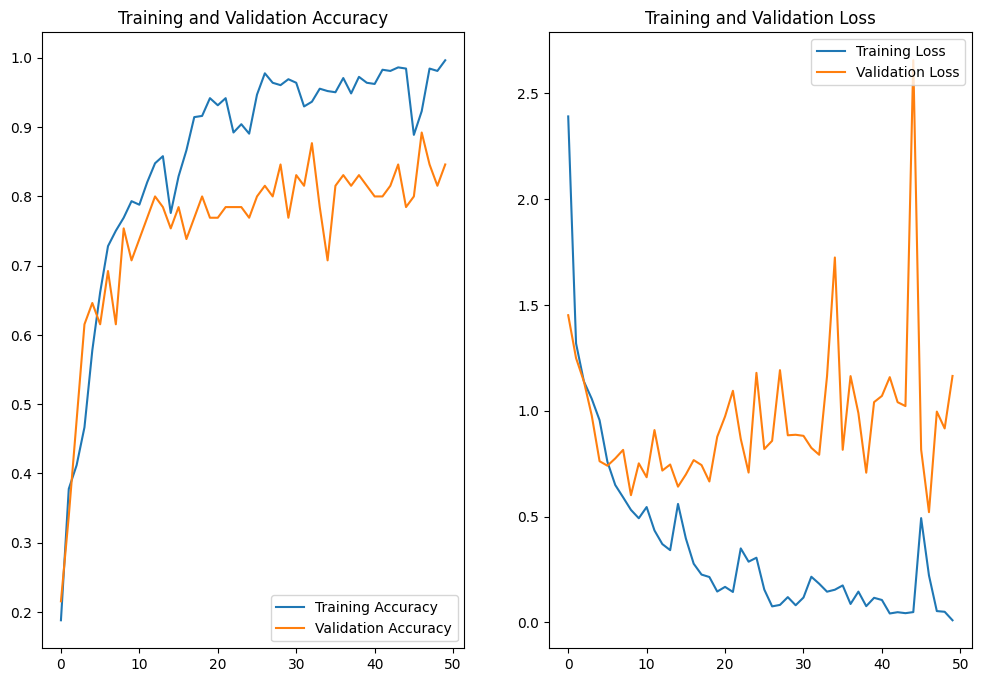

In [17]:
acc = historyA.history['accuracy']
val_acc = historyA.history['val_accuracy']

loss = historyA.history['loss']
val_loss = historyA.history['val_loss']

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

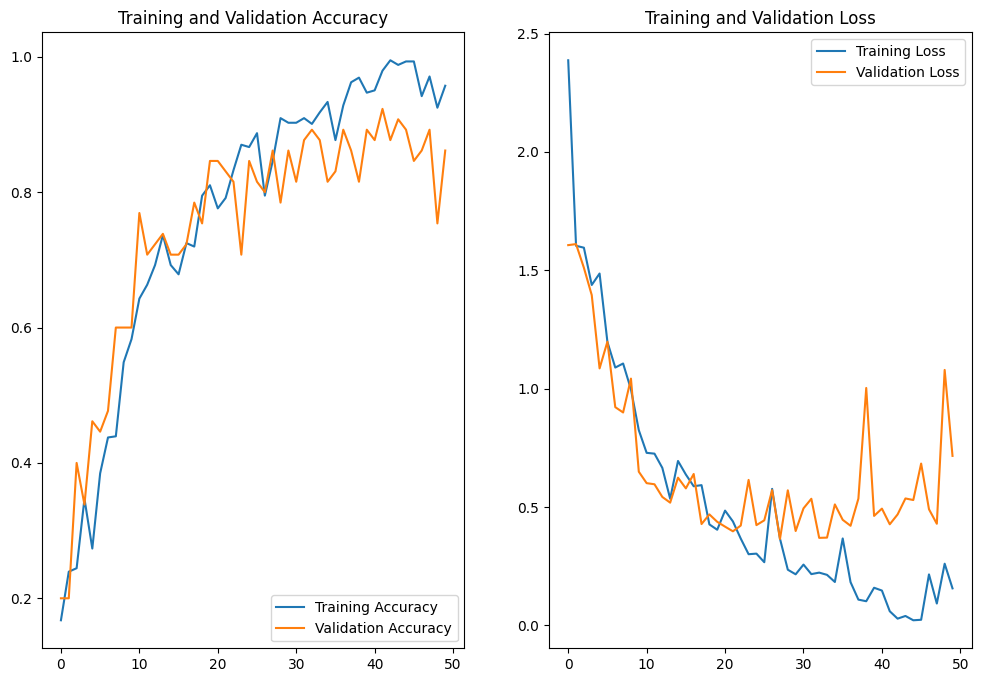

In [13]:
# 2 This is just graph from one of my attempts

# acc = historyA.history['accuracy']
# val_acc = historyA.history['val_accuracy']

# loss = historyA.history['loss']
# val_loss = historyA.history['val_loss']

# plt.figure(figsize=(12, 8))
# plt.subplot(1, 2, 1)
# plt.plot( acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

## Testing for Evaluation

In [ ]:
# test_path_for_eval = os.path.join(main_dir, "test")
test_path_for_eval = ""

for filename in os.listdir(test_path_for_eval):
  img_path = os.path.join(test_path_for_eval, filename)
  image = Image.open(img_path)
  image = train_basic(image=np.array(image))
  image = image['image']
  image = np.array(image) / 255.0
  image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
  pred_class = modelA.predict(image, verbose=0)
  print(f"{filename} -- class{np.argmax(pred_class)+1}")


# NOT MAIN IMPLEMENTATION PART

## My testing during experiments

In [12]:
def load_test_images_from_folder(folder):
    images = []
    labels = []
    for dir in os.listdir(folder):
      for filename in os.listdir(os.path.join(folder,dir)):
          image_path = os.path.join(folder,dir, filename)
          label = int(dir[-1])-1
          image = Image.open(image_path)

          image = train_basic(image=np.array(image))
          image = image['image']
          images.append(image)
          labels.append(label)
          del image
      print(f"Finished {dir}")
    return np.array(images)/255.0, np.array(labels)

In [13]:
X_test, y_test = load_test_images_from_folder(test_dir)
print(X_test.shape, y_test.shape)

Finished class3
Finished class4
Finished class5
Finished class2
Finished class1
(25, 224, 224, 3) (25,)


In [14]:
test_labels = to_categorical(y_test, num_classes=5)

In [18]:
eval_hst = modelA.evaluate(X_test, test_labels)

1/1 [==============================] - 1s 540ms/step - loss: 0.0221 - accuracy: 1.0000


# Previous Attempts

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [4]:
main_dir = "./train_dataset/"
train_dir = main_dir + "train"
test_dir = main_dir + "test"

validation_split = 0.1
batch_size = 32
IMG_Shape = 224

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_Shape, IMG_Shape),  # adjust to your desired image size
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_Shape, IMG_Shape),  # adjust to your desired image size
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 295 images belonging to 5 classes.
Found 30 images belonging to 5 classes.


In [ ]:
print(train_generator.class_indices)

{'class1': 0, 'class2': 1, 'class3': 2, 'class4': 3, 'class5': 4}


## Try 1

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_Shape, IMG_Shape, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
EPOCHS = 30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // batch_size),
    callbacks=[es],
)


Epoch 1/30
9/9 [==============================] - 9s 501ms/step - loss: 2.1091 - accuracy: 0.2015 - val_loss: 1.5247 - val_accuracy: 0.3667
Epoch 2/30
9/9 [==============================] - 5s 589ms/step - loss: 1.4035 - accuracy: 0.3878 - val_loss: 1.0238 - val_accuracy: 0.4667
Epoch 3/30
9/9 [==============================] - 6s 641ms/step - loss: 1.1515 - accuracy: 0.4411 - val_loss: 0.8963 - val_accuracy: 0.5333
Epoch 4/30
9/9 [==============================] - 5s 527ms/step - loss: 1.0154 - accuracy: 0.4981 - val_loss: 0.8886 - val_accuracy: 0.5000
Epoch 5/30
9/9 [==============================] - 6s 716ms/step - loss: 0.9826 - accuracy: 0.5285 - val_loss: 0.7803 - val_accuracy: 0.6000
Epoch 6/30
9/9 [==============================] - 5s 516ms/step - loss: 0.7883 - accuracy: 0.6540 - val_loss: 0.8572 - val_accuracy: 0.6000
Epoch 7/30
9/9 [==============================] - 6s 779ms/step - loss: 0.8377 - accuracy: 0.6350 - val_loss: 0.7472 - val_accuracy: 0.6000
Epoch 8/30
9/9 [====

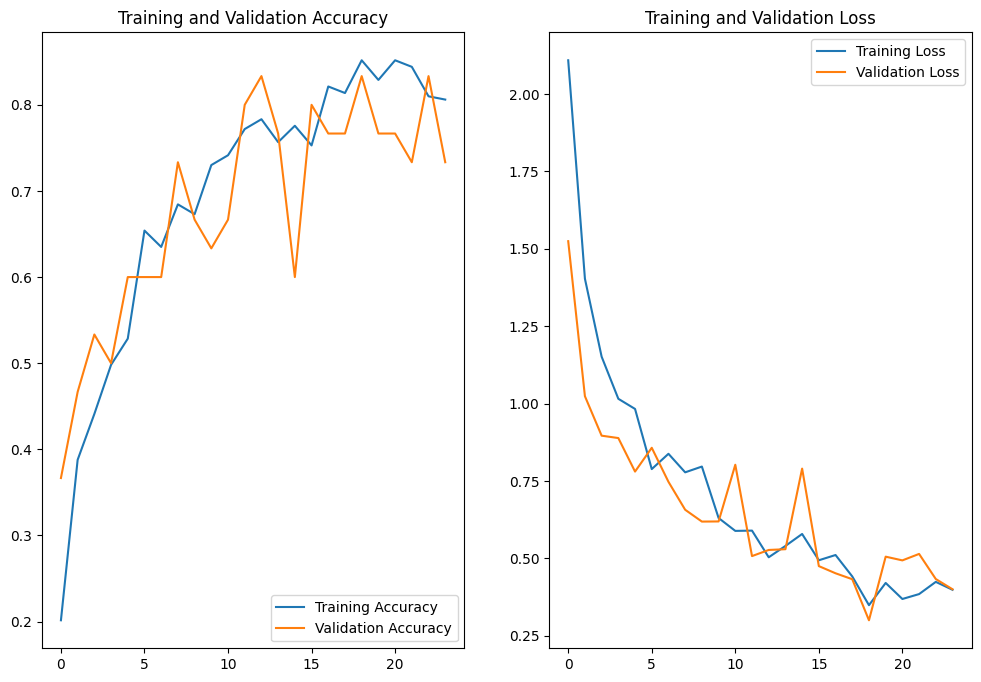

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)
# print(acc)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Try 2

In [ ]:
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_Shape, IMG_Shape, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model2.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
EPOCHS = 30
history = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // batch_size),
    # callbacks=[es],
)


Epoch 1/30
9/9 [==============================] - 16s 607ms/step - loss: 1.9209 - accuracy: 0.2586 - val_loss: 1.2427 - val_accuracy: 0.3667
Epoch 2/30
9/9 [==============================] - 6s 666ms/step - loss: 1.2894 - accuracy: 0.4487 - val_loss: 0.9361 - val_accuracy: 0.5000
Epoch 3/30
9/9 [==============================] - 5s 562ms/step - loss: 1.0931 - accuracy: 0.5247 - val_loss: 0.8802 - val_accuracy: 0.5667
Epoch 4/30
9/9 [==============================] - 6s 670ms/step - loss: 0.9750 - accuracy: 0.5399 - val_loss: 0.6084 - val_accuracy: 0.6667
Epoch 5/30
9/9 [==============================] - 5s 563ms/step - loss: 0.7818 - accuracy: 0.6540 - val_loss: 0.5584 - val_accuracy: 0.7333
Epoch 6/30
9/9 [==============================] - 6s 724ms/step - loss: 0.7715 - accuracy: 0.6350 - val_loss: 0.8195 - val_accuracy: 0.6000
Epoch 7/30
9/9 [==============================] - 7s 786ms/step - loss: 0.7479 - accuracy: 0.6882 - val_loss: 0.5516 - val_accuracy: 0.7000
Epoch 8/30
9/9 [===

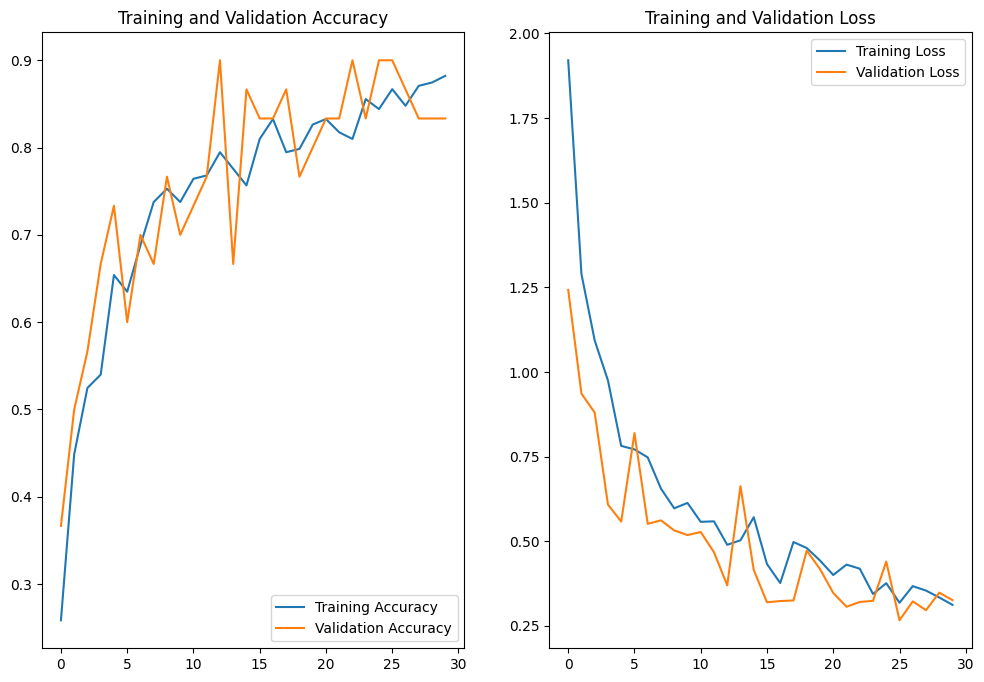

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)
# print(acc)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Try 3

In [ ]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  
])

model3.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
EPOCHS = 50
history = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // batch_size),
    # callbacks=[es],
)


Epoch 1/50
9/9 [==============================] - 9s 774ms/step - loss: 2.3826 - accuracy: 0.1825 - val_loss: 1.5555 - val_accuracy: 0.4000
Epoch 2/50
9/9 [==============================] - 5s 551ms/step - loss: 1.4762 - accuracy: 0.3346 - val_loss: 1.1200 - val_accuracy: 0.5000
Epoch 3/50
9/9 [==============================] - 7s 830ms/step - loss: 1.1253 - accuracy: 0.4677 - val_loss: 0.8460 - val_accuracy: 0.4667
Epoch 4/50
9/9 [==============================] - 5s 557ms/step - loss: 0.9666 - accuracy: 0.5856 - val_loss: 0.8091 - val_accuracy: 0.5000
Epoch 5/50
9/9 [==============================] - 6s 667ms/step - loss: 0.8401 - accuracy: 0.5972 - val_loss: 0.7846 - val_accuracy: 0.5667
Epoch 6/50
9/9 [==============================] - 6s 621ms/step - loss: 0.7718 - accuracy: 0.6540 - val_loss: 0.5545 - val_accuracy: 0.7667
Epoch 7/50
9/9 [==============================] - 7s 749ms/step - loss: 0.6156 - accuracy: 0.7605 - val_loss: 0.6055 - val_accuracy: 0.6000
Epoch 8/50
9/9 [====

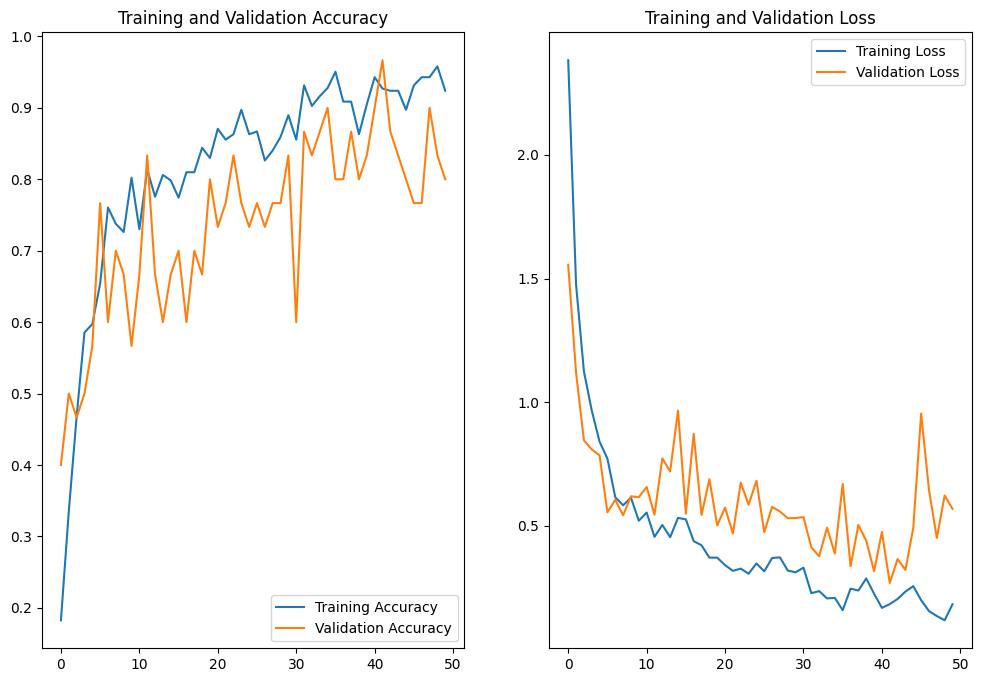

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)
# print(acc)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Try 4

In [16]:

encoded_labels = to_categorical(y, num_classes=5)

In [18]:
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  
])

model4.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [20]:
history = model4.fit(
    X, encoded_labels,
    epochs=20,
    batch_size = 64,
    # steps_per_epoch=len(X)//16,
    validation_split=validation_split,
    # callbacks=[es],
)

Epoch 1/20
10/10 [==============================] - 15s 211ms/step - loss: 2.0232 - accuracy: 0.2564 - val_loss: 1.8975 - val_accuracy: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 1s 97ms/step - loss: 1.3214 - accuracy: 0.3949 - val_loss: 1.5890 - val_accuracy: 0.0154
Epoch 3/20
10/10 [==============================] - 1s 99ms/step - loss: 0.9801 - accuracy: 0.5265 - val_loss: 1.5364 - val_accuracy: 0.2308
Epoch 4/20
10/10 [==============================] - 1s 99ms/step - loss: 0.7665 - accuracy: 0.6547 - val_loss: 0.6123 - val_accuracy: 0.8615
Epoch 5/20
10/10 [==============================] - 1s 156ms/step - loss: 0.7273 - accuracy: 0.6889 - val_loss: 0.6198 - val_accuracy: 0.8000
Epoch 6/20
10/10 [==============================] - 2s 164ms/step - loss: 0.5598 - accuracy: 0.7795 - val_loss: 0.5609 - val_accuracy: 0.7692
Epoch 7/20
10/10 [==============================] - 2s 182ms/step - loss: 0.4629 - accuracy: 0.8137 - val_loss: 0.2357 - val_accuracy: 0.9231
Epoc

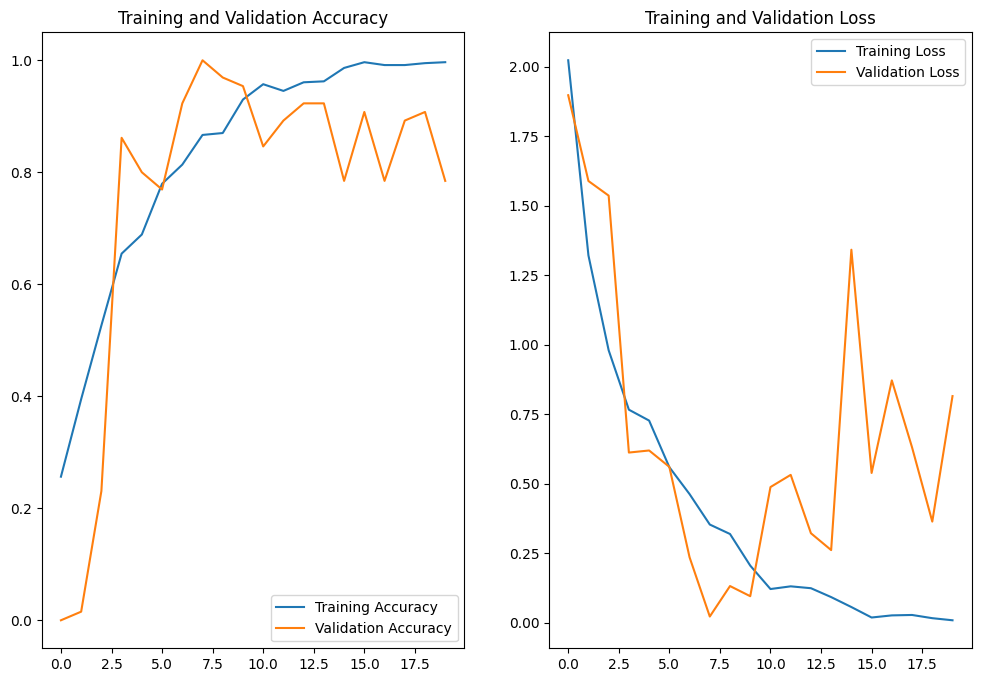

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)
# print(acc)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
eval_hst = model4.evaluate(X_test, test_labels)

1/1 [==============================] - 1s 522ms/step - loss: 0.6661 - accuracy: 0.8000


In [14]:
model5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  # Assuming 5 flower classes
])

model5.compile(optimizer='adam',
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [16]:
history5 = model5.fit(
    x_train, y_train,
    epochs=20,
    batch_size = 64,
    # steps_per_epoch=len(X)//16,
    # validation_split=validation_split,
    validation_data = (x_val, y_val),
    callbacks=[es],
)

Epoch 1/20
10/10 [==============================] - 9s 201ms/step - loss: 2.2455 - accuracy: 0.2427 - val_loss: 1.4865 - val_accuracy: 0.3846
Epoch 2/20
10/10 [==============================] - 1s 100ms/step - loss: 1.2988 - accuracy: 0.3915 - val_loss: 1.1012 - val_accuracy: 0.4923
Epoch 3/20
10/10 [==============================] - 1s 101ms/step - loss: 0.9638 - accuracy: 0.5521 - val_loss: 1.0199 - val_accuracy: 0.6000
Epoch 4/20
10/10 [==============================] - 1s 102ms/step - loss: 0.7485 - accuracy: 0.6684 - val_loss: 1.0410 - val_accuracy: 0.6308
Epoch 5/20
10/10 [==============================] - 1s 101ms/step - loss: 0.6206 - accuracy: 0.7419 - val_loss: 1.0025 - val_accuracy: 0.5846
Epoch 6/20
10/10 [==============================] - 1s 101ms/step - loss: 0.5612 - accuracy: 0.7556 - val_loss: 0.7883 - val_accuracy: 0.6615
Epoch 7/20
10/10 [==============================] - 1s 121ms/step - loss: 0.4239 - accuracy: 0.8342 - val_loss: 0.8433 - val_accuracy: 0.7385
Epoch 

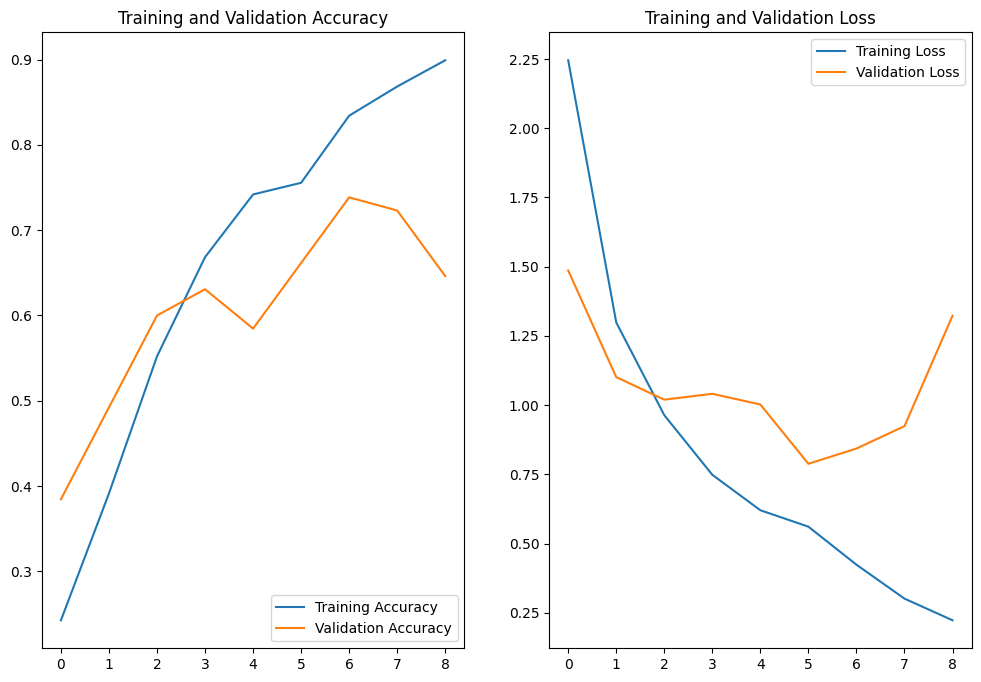

In [17]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

# epochs_range = range(EPOCHS)
# print(acc)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
eval_hst = model5.evaluate(X_test, test_labels)

1/1 [==============================] - 1s 560ms/step - loss: 0.4614 - accuracy: 0.8000
